In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL.Image import fromarray
from torchvision import transforms
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import BertModel, BertTokenizer

import seaborn as sns

In [2]:
def load_image_from_path(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def preprocess(img, w_max, gamma):
    h, w, c = img.shape
    wf, hf = w_max, 1 if int(h*w_max/w) == 0 else int(h*w_max/w)
    img = cv2.resize(img, (wf, hf), interpolation = cv2.INTER_AREA)
    img = 255*(img/255.)**gamma
    img = img.astype(np.uint8)
    return img, (w, h), (wf, hf)

In [3]:
def load_image(image_path, w_max, gamma, hardcoded_range):
    img = load_image_from_path(image_path)
    hd1, hd2 = hardcoded_range
    hardcoded_img = img[hd1: hd2]
    img, (w, h), (wf, hf) = preprocess(img, w_max, gamma)
    hardcoded_img, (_, _), (_, _) = preprocess(hardcoded_img, w_max, gamma)
    wr, hr = wf/w, hf/h
    return img, hardcoded_img, (wf, hf), (wr, hr)

def thresholding(image, threshold):
    # grayscaling the image
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # all pixels below threshold will turn black and rest will become 255
    _, thresh_img = cv2.threshold(img_gray, threshold, 255, cv2.THRESH_BINARY_INV)
    return thresh_img


def dilate(thresh_img, kernel_dims):
    kernel = np.ones(kernel_dims, np.uint8)
    dilated_img = cv2.dilate(thresh_img, kernel, iterations = 1)
    return dilated_img


In [4]:
def generate_para(img, threshold, kernel_dims):
    thresh_img = thresholding(img, threshold)
    dilated_img = dilate(thresh_img, kernel_dims)

    (contours, heirarchy) = cv2.findContours(dilated_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    
    para_list = []
    para_images = []

    for ctr in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(ctr)
        area = cv2.contourArea(ctr)
        aspect_ratio = float(w) / h
        para_list.append([x, y, w, h])
        para_images.append(img[y:y+h, x:x+w])
        break
        
    return para_images[0], para_list[0]

In [5]:
def get_img_and_vars(image_path, w_max, gamma, hardcoded_range, threshold, kernel_dims):
    img, himg, (wf, hf), (wr, hr) = load_image(image_path, w_max, gamma, hardcoded_range)
    para_img, (x,y,w,h) = generate_para(himg, threshold, kernel_dims)
    y = y + HARDCODED_RANGE[0]*hr
    y = int(y)
    return img, (x,y,w,h), (x/wf, y/hf, w/wf, h/hf)

In [6]:
image_transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])

def return_tensor(image):
    image = fromarray(image)
    return image_transform(image)

---

In [7]:
GAMMA = 2
W_MAX = 1000
THRESHOLD = 40
KERNEL_DIMS = (85,85)
HARDCODED_RANGE = (710,2800)

In [8]:
image_path = '/kaggle/input/iam-handwritten-forms-dataset/data/000/a01-000u.png'

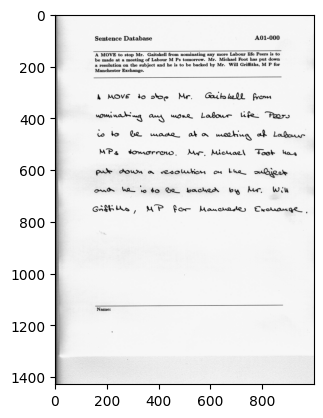

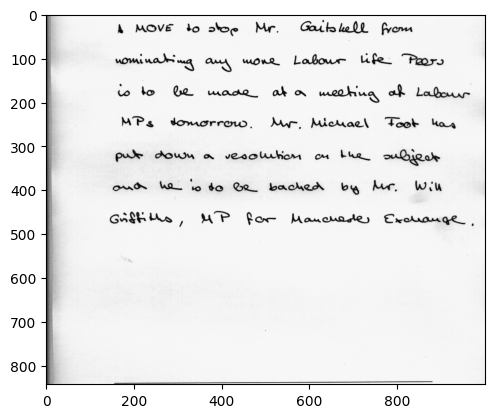

In [9]:
img, himg, (wf, hf), (wr, hr) = load_image(image_path, W_MAX, GAMMA, HARDCODED_RANGE)
plt.imshow(img)
plt.show()
plt.imshow(himg)
plt.show()

(104, 286, 896, 527)


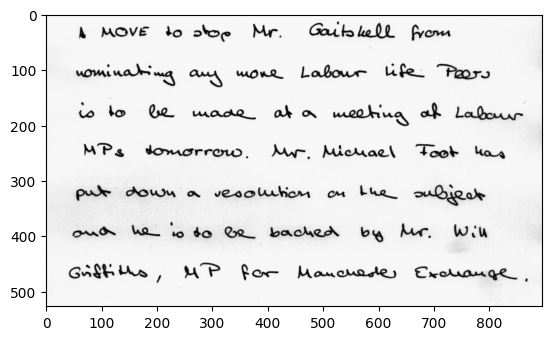

In [10]:
para_img, (x,y,w,h) = generate_para(himg, THRESHOLD, KERNEL_DIMS)
plt.imshow(para_img)
y = y + HARDCODED_RANGE[0]*hr
y = int(y)
print((x,y,w,h))
plt.show()

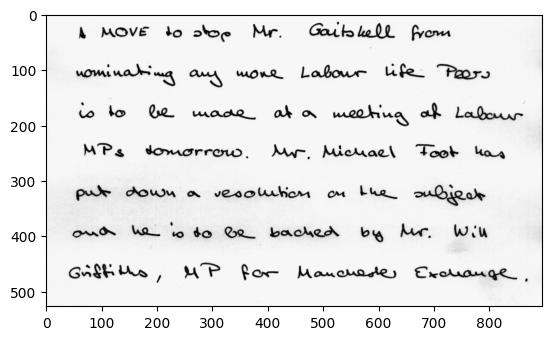

In [11]:
plt.imshow(img[y:y+h, x:x+w])
plt.show()

In [12]:
img, (x,y,w,h), _ = get_img_and_vars(image_path, W_MAX, GAMMA, HARDCODED_RANGE, THRESHOLD, KERNEL_DIMS)

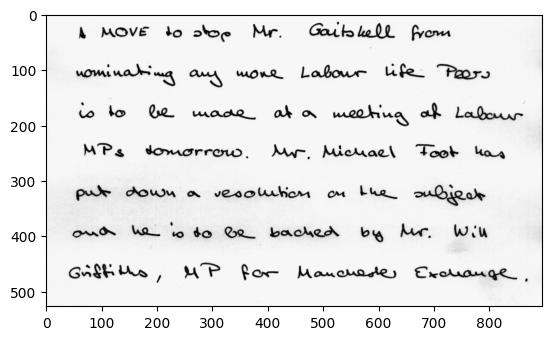

In [13]:
plt.imshow(img[y:y+h, x:x+w])
plt.show()

/kaggle/input/iam-handwritten-forms-dataset/data/515/m01-115.png


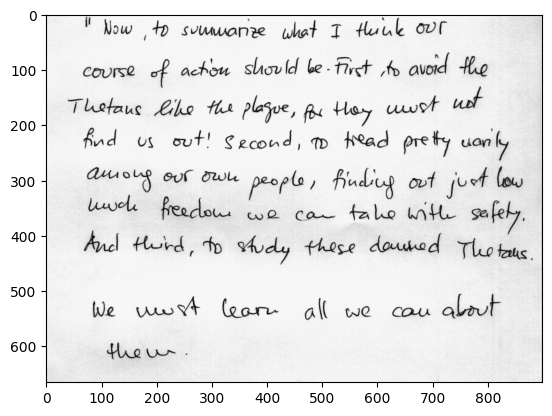

In [14]:
maindir = '/kaggle/input/iam-handwritten-forms-dataset/data'
for subdir in os.listdir(maindir):
    subdir_path = os.path.join(maindir, subdir)
    for img_file in os.listdir(subdir_path):
        img_file_path = os.path.join(subdir_path, img_file)
        print(img_file_path)
        img, himg, (wf, hf), (wr, hr) = load_image(img_file_path, W_MAX, GAMMA, HARDCODED_RANGE)
        para_img, (x,y,w,h) = generate_para(himg, THRESHOLD, KERNEL_DIMS)
        y = y + HARDCODED_RANGE[0]*hr
        y = int(y)
        plt.imshow(img[y:y+h, x:x+w])
        plt.show()
        break
    break

In [15]:
df = pd.read_csv('/kaggle/input/parasegmentation/paraseg.csv')

In [16]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.image_paths = df['image_path'].tolist()
        x = df['x'].tolist()
        y = df['y'].tolist()
        w = df['w'].tolist()
        h = df['h'].tolist()
        
        labels = np.array([x, y, w, h])
        self.labels = labels.T.tolist()

    def __len__(self):
        return df.shape[0]
    
    def __getitem__(self, idx):
        img_path, label = self.image_paths[idx], self.labels[idx]
        img = load_image_from_path(img_path)
        img, _, _ = preprocess(img, W_MAX, GAMMA)
        img_tensor = return_tensor(img)
        return img_tensor, label

In [17]:
dataset = CustomDataset(df)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [18]:
for each in data_loader:
    img = each[0][0]
    x = each[1][0][0]
    y = each[1][1][0]
    w = each[1][2][0]
    h = each[1][3][0]
    print(img.shape)
    print(x,y,w,h)
    break

torch.Size([1, 1428, 1000])
tensor(0.0910, dtype=torch.float64) tensor(0.2003, dtype=torch.float64) tensor(0.8460, dtype=torch.float64) tensor(0.3158, dtype=torch.float64)


In [19]:
import torch
import torch.nn as nn
from torchvision import models

class ResNet34(nn.Module):
    def __init__(self):
        super(ResNet34, self).__init__()

        # Load pre-trained ResNet34 model
        self.resnet = models.resnet34(pretrained=True)

        # Modify the first convolutional layer to accommodate grayscale images
        conv1_weight = self.resnet.conv1.weight.data
        conv1_weight = conv1_weight.mean(dim=1, keepdim=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.conv1.weight.data = conv1_weight

        # Remove the last fully connected layer of ResNet34
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])

        # Freeze the ResNet layers so they won't be trained
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Add fully connected layers
        self.fc1 = nn.Linear(512, 64)  # ResNet34 outputs 512 features
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 4)  # Output layer with 4 units for bounding box coordinates
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass through ResNet layers
        x = self.resnet(x)

        # Flatten the output of ResNet
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)  # Applying sigmoid activation for bounding box coordinates

        return x

In [20]:
resnet = ResNet34()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 67.1MB/s]


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet34().to(device)
model.load_state_dict(torch.load('/kaggle/input/htr-models/model.pth'))

<All keys matched successfully>

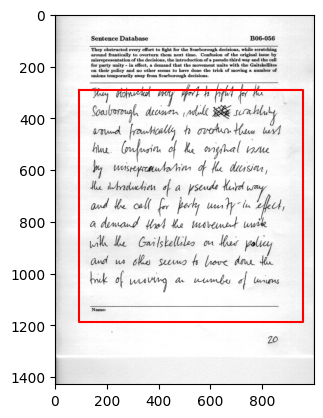

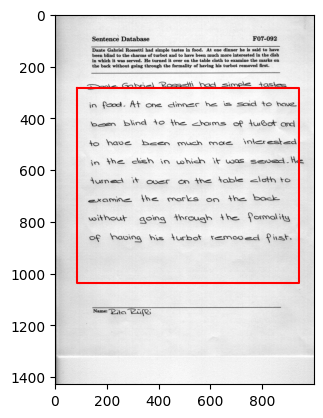

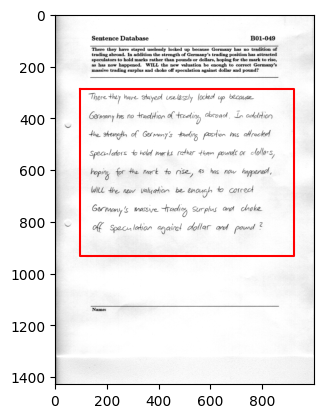

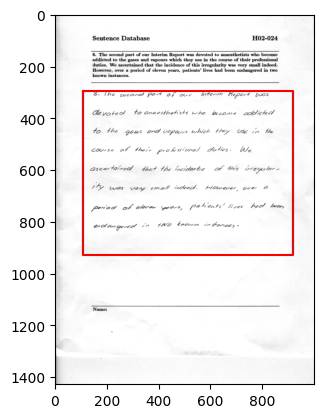

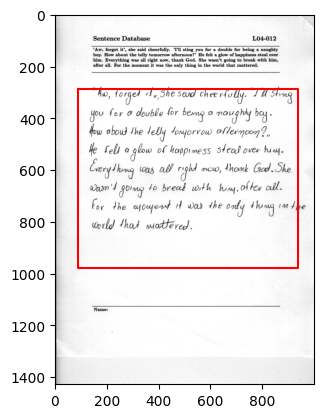

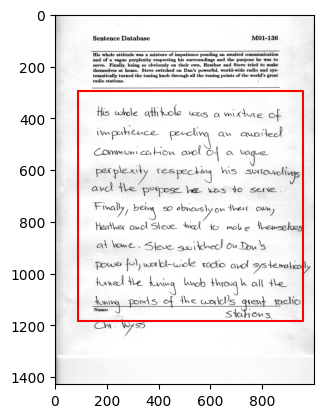

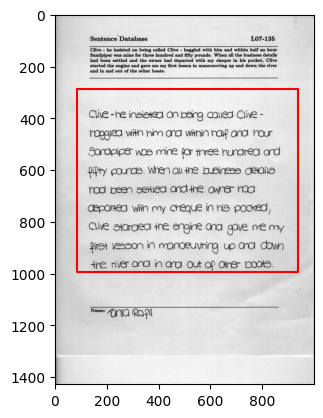

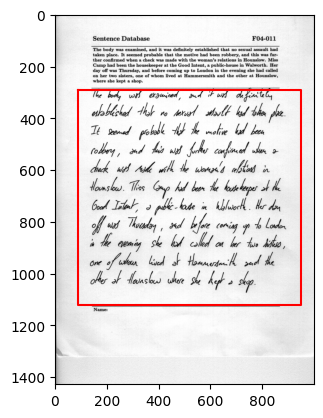

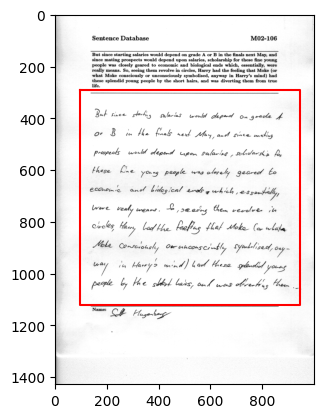

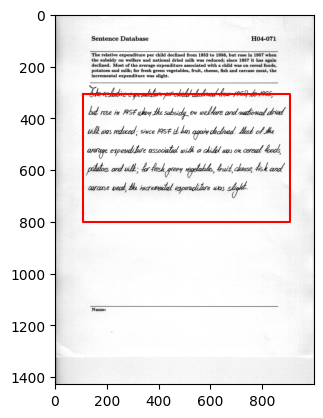

In [22]:
for images, _ in data_loader:
    images = images.to(device)
    y_hat = model(images)
    break
    
for i in range(10):
    x, y, w, h = y_hat[i].detach()

    x = x.cpu().numpy()
    y = y.cpu().numpy()
    w = w.cpu().numpy()
    h = h.cpu().numpy()

    image = images[i]

    height, width = image.shape[1], image.shape[2]

    x_left_top, y_left_top = x * width, y * height
    width, height = w * width, h * height

    x_right_top = x_left_top + width
    y_left_bottom = y_left_top + height
    plt.imshow(image.cpu().squeeze(), cmap='gray')
    plt.plot([x_left_top, x_left_top, x_right_top, x_right_top, x_left_top],
             [y_left_top, y_left_bottom, y_left_bottom, y_left_top, y_left_top],
             color='red')
    

    plt.show()

In [23]:
def crop_images(images, y_hat):
    cropped_images = []

    for i in range(y_hat.shape[0]):  # Loop over each image in the batch
        x, y, w, h = y_hat[i].detach().cpu().numpy()  # Get bounding box coordinates for the ith image
        image = images[i].cpu().squeeze()  # Get the ith image from the batch

        height, width = image.shape[0], image.shape[1]

        x_left_top, y_left_top = int(x * width), int(y * height)
        width, height = int(w * width), int(h * height)
        x_right_top = x_left_top + width
        y_left_bottom = y_left_top + height

        # Get the cropped image
        cropped_image = image[y_left_top:y_left_bottom, x_left_top:x_right_top]

        cropped_images.append(cropped_image)

    # Resize each cropped image to the maximum width and height
    resize_transform = transforms.Resize((930, 890))

    resized_images = [resize_transform(torch.unsqueeze(img, 0)) for img in cropped_images]
    
    # Stack the resized images
    stacked_images = torch.stack(resized_images)
    
    return stacked_images

In [5]:
!pip install transformers
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from IPython.display import display
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten") 
trcocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

2024-04-10 11:00:52.078734: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 11:00:52.078867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 11:00:52.209171: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
def ocr_image(img):
    pixel_values = processor(images=img, return_tensors="pt").pixel_values
    generated_ids = trcocr_model.generate(pixel_values)
    return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [7]:
tensor_to_img_transform = transforms.ToPILImage()

def line_to_text(line_img_tensor):
    line_img = tensor_to_img_transform(line_img_tensor)
    text = image_to_string(line_img)
    return text

In [10]:
def preprocess(img, w_max, gamma):
    h, w, c = img.shape
    wf, hf = w_max, 1 if int(h*w_max/w) == 0 else int(h*w_max/w)
    img = cv2.resize(img, (wf, hf), interpolation = cv2.INTER_AREA)
    img = 255*(img/255.)**gamma
    img = img.astype(np.uint8)
    return img, (w, h), (wf, hf)

In [11]:
def tensor_to_cvarray(img_tensor):
    img = tensor_to_img_transform(img_tensor)
    cv_img = np.array(img)
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_RGB2BGR)
    return cv_img

In [12]:
def thresholding(image, threshold):
    # grayscaling the image
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # all pixels below threshold will turn black and rest will become 255
    _, thresh_img = cv2.threshold(img_gray, threshold, 255, cv2.THRESH_BINARY_INV)
    return thresh_img


def dilate(thresh_img, kernel_dims):
    kernel = np.ones(kernel_dims, np.uint8)
    dilated_img = cv2.dilate(thresh_img, kernel, iterations = 1)
    return dilated_img

In [13]:
from statistics import median

In [14]:
def return_tensor(image, w=900, h=30):
    image = fromarray(image)
    image = transforms.Compose([transforms.Resize((h,w)), transforms.Grayscale(), transforms.ToTensor()])(image)
    return image

In [15]:
def generate_lines(img_tensor, w_max, gamma, threshold, kernel_dims, num_lines_threshold=4):
    img = tensor_to_cvarray(img_tensor)
    img, _, _ = preprocess(img, w_max, gamma)
    thresh_img = thresholding(img, threshold)
    dilated_img = dilate(thresh_img, kernel_dims)

    (contours, heirarchy) = cv2.findContours(dilated_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    
    lines_images = []

    for ctr in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(ctr)
        area = cv2.contourArea(ctr)
        aspect_ratio = float(w) / h
        if w >= 100 and h >= 20 and area>=10000:
            lines_images.append(img[y:y+h, x:x+w])
            
    if len(lines_images) <= num_lines_threshold:
        lines_images = []
    
    lines_tensor_list = []
    lines_text_list = []
    for each in lines_images:
        lines_tensor_list.append(return_tensor(each, 900, 30))
        lines_text_list.append(ocr_image(each))
    
    return lines_tensor_list, lines_text_list

In [24]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()

        # Load pre-trained ResNet34 model
        self.resnet = models.resnet34(pretrained=True)

        # Modify the first convolutional layer to accommodate grayscale images
        conv1_weight = self.resnet.conv1.weight.data
        conv1_weight = conv1_weight.mean(dim=1, keepdim=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.conv1.weight.data = conv1_weight

        # Remove the last fully connected layer of ResNet34
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])

        # Freeze the ResNet layers so they won't be trained
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Forward pass through ResNet layers
        x = self.resnet(x)
        return x

In [224]:
resnet = FeatureExtractor().to(device)
y_hat = resnet(line1)
print(y_hat.shape)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 512, 1, 29])


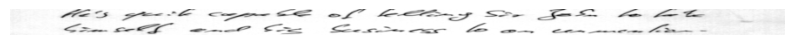

In [225]:
plt.figure(figsize=(10, 6))
plt.imshow(line1[0][0].cpu(), cmap='gray')
plt.axis('off')
plt.show()

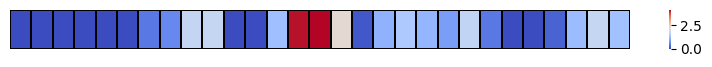

In [227]:
plt.figure(figsize=(10, 0.5))
sns.heatmap(y_hat[0][0].detach().cpu().numpy(), cmap='coolwarm', linewidths=0.1, linecolor='black')
plt.axis('off')
plt.show()

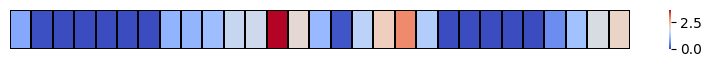

In [228]:
plt.figure(figsize=(10, 0.5))
sns.heatmap(y_hat[0][1].detach().cpu().numpy(), cmap='coolwarm', linewidths=0.1, linecolor='black')
plt.axis('off')
plt.show()

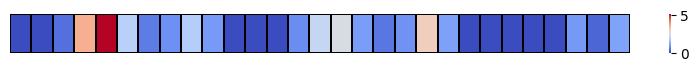

In [229]:
plt.figure(figsize=(10, 0.5))
sns.heatmap(y_hat[0][2].detach().cpu().numpy(), cmap='coolwarm', linewidths=0.1, linecolor='black')
plt.axis('off')
plt.show()

In [220]:
class LSTMDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_unique_chars, dropout=0.1):
        super(LSTMDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_unique_chars = num_unique_chars
        self.dropout = nn.Dropout(dropout)
        # Set bidirectional=True for bidirectional LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        # Double the hidden size due to bidirectional LSTM
        self.fc = nn.Linear(hidden_size * 2, num_unique_chars)  # Multiply by 2 for bidirectional LSTM

    def forward(self, input_seq, hidden=None):
        batch_size = input_seq.size(0)
        seq_len = input_seq.size(1)

        if hidden is None:
            hidden = self.init_hidden(batch_size)

        output, hidden = self.lstm(input_seq, hidden)
        output = self.dropout(output)
        output = output.contiguous().view(-1, self.hidden_size * 2)  # Multiply by 2 for bidirectional LSTM
        output = self.fc(output)
        output = output.view(batch_size, seq_len, self.num_unique_chars)
        return output

    def init_hidden(self, batch_size):
        # Double the hidden size due to bidirectional LSTM
        h = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(device)
        c = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(device)
        return h, c

In [221]:
y_hat = resnet(line1)
y_hat = y_hat.squeeze(2).permute(2, 0, 1)

input_shape = 512
hidden_size = 1024
num_layers = 2
num_unique_chars = 79
max_sequence_length = 100
batch_size = 1
sequence_length = 50

decoder = LSTMDecoder(input_shape, hidden_size, num_layers, num_unique_chars).to(device)
outputs = decoder(y_hat)

In [222]:
T = 29
C = 80
S = 100
S_min = 99

labels = torch.zeros(1, 100).to(device)
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
N = 1
optimizer.zero_grad()
outputs = decoder(y_hat)
input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
target_lengths = torch.randint(low=S_min, high=S, size=(N,), dtype=torch.long)
loss = criterion(outputs, labels, input_lengths, target_lengths)
print(loss)

tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)


---

In [25]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(Encoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(self.input_dim, self.hidden_dim, num_layers=self.num_layers)
              
    def forward(self, x):
        outputs, hidden = self.gru(x)
        return outputs, hidden

In [96]:
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers):
        super(Decoder, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, self.hidden_dim, num_layers=self.num_layers)
        self.out = nn.Linear(self.hidden_dim, output_dim)
        self.log_softmax = nn.LogSoftmax()

    def forward(self, x, hidden):
        x = x.view(1, -1)
        output, hidden = self.gru(x, hidden)   
        prediction = self.log_softmax(self.out(output[0]))

        return prediction, hidden

In [97]:
class Seq2Seq(nn.Module):
    def __init__(self, enc_input_dim, dec_input_dim, hidden_dim, target_length=100, num_chars=80):
        super(Seq2Seq, self).__init__()
        self.target_length = target_length
        self.num_chars = num_chars
        
        self.encoder = Encoder(
            input_dim=enc_input_dim,
            hidden_dim=hidden_dim,
            num_layers=1
        ).to(device)
        
        self.decoder = Decoder(
            input_dim=dec_input_dim,
            output_dim=dec_input_dim,
            hidden_dim=hidden_dim,
            num_layers=1
        ).to(device)
        
    def forward(self, features):
        seq_length = features.shape[0]
        
        for i in range(seq_length):
            enc_output, enc_hidden = self.encoder(features[i])
            
        outputs = torch.zeros(self.target_length, self.num_chars).to(device)
        
        dec_hidden = enc_hidden
        dec_input = torch.zeros(1, num_chars).to(device)

        for i in range(self.target_length):
            decoder_output, dec_hidden = self.decoder(dec_input, dec_hidden)
            outputs[i] = decoder_output
            dec_input = decoder_output
            
        return outputs

In [98]:
class HandwrittenLineRecognizer(nn.Module):
    def __init__(self, feature_extractor, seq2seq):
        super(HandwrittenLineRecognizer, self).__init__()
        self.feature_extractor = feature_extractor.to(device)
        self.seq2seq = seq2seq.to(device)
        
    def forward(self, line):
        features = self.feature_extractor(line)
        features = features.squeeze(2).permute(2, 0, 1)
        output = self.seq2seq(features)
        
        return output

In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [100]:
enc_input_dim = 512
dec_input_dim = 80
hidden_dim = 256
target_length = 150
num_chars = 80

feature_extractor = FeatureExtractor()
seq2seq = Seq2Seq(enc_input_dim, dec_input_dim, hidden_dim, target_length, num_chars)

model = HandwrittenLineRecognizer(feature_extractor, seq2seq).to(device)

In [101]:
char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz " 

In [102]:
class LinesDataset(Dataset):
    def __init__(self, lines_images, lines_labels):
        self.lines_images = np.array(lines_images)
        self.lines_labels = np.array(lines_labels)
        
    def __len__(self):
        return len(self.lines_images)
    
    def __getitem__(self, idx):
        return (self.lines_images[idx], self.lines_labels[idx])

In [103]:
dataset = torch.load('/kaggle/input/iam-forms-line-dataset/dataset.pt')

In [104]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [151]:
largest_label = None
max_index = -1
num_greater_50 = 0
freq = []

for _, labels in dataloader:
    labels = labels[0]  # Assuming labels is a tensor of size 150
    for i in range(150):
        label = labels[i]
        if label == 79:
            
            if i > 55:
                num_greater_50 += 1
            break

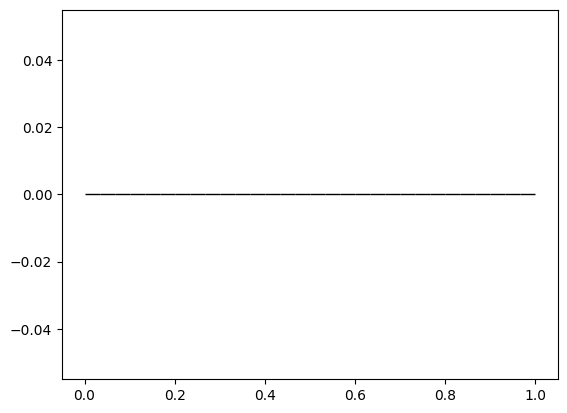

In [160]:
import matplotlib.pyplot as plt
plt.hist(freq, bins=30, color='skyblue', edgecolor='black')
plt.show()

In [152]:
print(num_greater_50)

942


In [145]:
len(dataloader)

10227

In [142]:
print(get_text(largest_label))

Categories Living peopleAmerican people from London1940s in the United StatesAmerican women writersAmerican


In [165]:
# Loss function
criterion = nn.CTCLoss(blank=79, zero_infinity=True)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [170]:
import torch.nn.functional as F

In [ ]:
for epoch in range(1):
    losses = []
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        N = images.shape[0]
        optimizer.zero_grad()

        outputs = model(images).unsqueeze(0)
        outputs = outputs.permute(0, 2, 1)
        loss = F.cross_entropy(outputs.contiguous().view(-1, C), labels.view(-1))
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        if (i + 1) % 500 == 0:
            print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {np.round(loss.item(), 3)}")

    print(f"Epoch {epoch + 1} : Loss : {np.round(np.mean(losses), 3)}")

Epoch 1, Batch 500, Loss: 3.126
Epoch 1, Batch 1000, Loss: 3.182
Epoch 1, Batch 1500, Loss: 2.928
Epoch 1, Batch 2000, Loss: 2.857
Epoch 1, Batch 2500, Loss: 3.445
Epoch 1, Batch 3000, Loss: 3.403
Epoch 1, Batch 3500, Loss: 2.982
Epoch 1, Batch 4000, Loss: 3.503
Epoch 1, Batch 4500, Loss: 4.038
Epoch 1, Batch 5000, Loss: 4.025


In [28]:
def plot_tensor(img, axis='off'):
    plt.imshow(img.permute(1,2,0), cmap='gray')
    if axis == 'off':
        plt.axis('off')
    plt.show()

In [35]:
char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz "

In [120]:
def get_text(sequence):
    text = ""
    for i in sequence:
        if i != 79:
            text += char_list[i]
    return text

In [55]:
def train(model, optimizer, criterion, max_length=150, num_classes=80):
    model.train()  # Set the model to training mode
    train_loss = 0
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    for batch_idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)  # Move images to device
        labels = labels.to(device)  # Move labels to device

        # Calculate the length of each target sequence
        target_lengths = torch.tensor([len(label) for label in labels], device=device)

        optimizer.zero_grad()  # Clear previous gradients

        # Generate output from the model
        output = model(images)  # (batch_size, max_length, num_classes)
        output_log_probs = nn.functional.log_softmax(output, dim=-1)

        # Create a tensor of lengths for each target sequence
        input_lengths = torch.full(size=(images.size(0),), fill_value=max_length, dtype=torch.int32, device=device)

        # Calculate the CTC loss
        loss = criterion(output_log_probs, labels, input_lengths, target_lengths)

        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update the model parameters

        train_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f'[{batch_idx * len(images)}/{len(dataloader.dataset)} ({100. * batch_idx / len(dataloader):.0f}%)]\tLoss: {loss.item():.6f}')

    train_loss /= len(dataloader)
    print(f'Train set: Average loss: {train_loss:.4f}')

    return train_loss

In [56]:
criterion = nn.CTCLoss(blank=0, reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss = train(hlr, optimizer, criterion)
print(loss)

[0/10227 (0%)]	Loss: inf



KeyboardInterrupt



In [143]:
enc_input_dim = 512
dec_input_dim = 80
hidden_dim = 256
target_length = 150
num_chars = 80

feature_extractor = FeatureExtractor()
seq2seq = Seq2Seq(enc_input_dim, dec_input_dim, hidden_dim, target_length, num_chars)

hlr = HandwrittenLineRecognizer(feature_extractor, seq2seq).to(device)

In [144]:
num_epochs = 100

model = hlr.to(device)
for epoch in range(num_epochs):
    losses = []
    num_batches = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        N = images.shape[0]
        optimizer.zero_grad()
        outputs = model(images)
        loss = 0
        for i in range(outputs.shape[0]):
            y_hat = outputs[i]
            label = labels[0][i]
            loss += criterion(y_hat, label)
        loss = loss / outputs.shape[0]
        losses.append(loss)
        loss.backward()
        optimizer.step()
        
        num_batches += 1
        if num_batches % 100 == 0:
            print(f'{num_batches} Batch over!, Loss : {loss.item()}')
    print(f"Epoch {epoch + 1} : Loss : {np.round(np.mean(losses), 3)}")

100 Batch over!, Loss : 4.382542610168457
200 Batch over!, Loss : 4.3826165199279785
300 Batch over!, Loss : 4.382656574249268
800 Batch over!, Loss : 4.382501602172852
900 Batch over!, Loss : 4.382554054260254
1000 Batch over!, Loss : 4.382511138916016
1100 Batch over!, Loss : 4.382692337036133
1200 Batch over!, Loss : 4.3825459480285645
1300 Batch over!, Loss : 4.38262939453125
1400 Batch over!, Loss : 4.38266134262085
1500 Batch over!, Loss : 4.382771015167236
1600 Batch over!, Loss : 4.382565975189209
1700 Batch over!, Loss : 4.382540702819824
1800 Batch over!, Loss : 4.382541656494141
1900 Batch over!, Loss : 4.382585048675537
2000 Batch over!, Loss : 4.3825364112854
2100 Batch over!, Loss : 4.382567882537842
2200 Batch over!, Loss : 4.382511615753174
2300 Batch over!, Loss : 4.382569789886475
2400 Batch over!, Loss : 4.382535457611084
2500 Batch over!, Loss : 4.382561683654785
2600 Batch over!, Loss : 4.38247537612915


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.